Random Seed:  8417
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

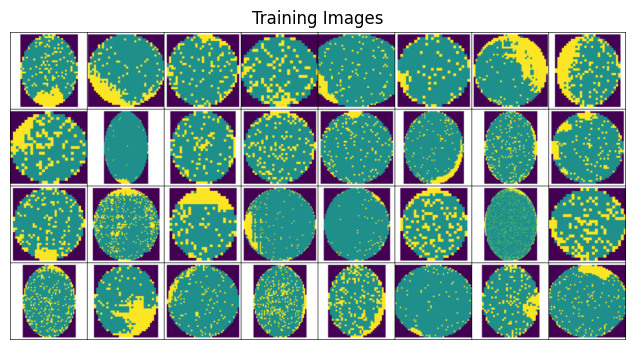

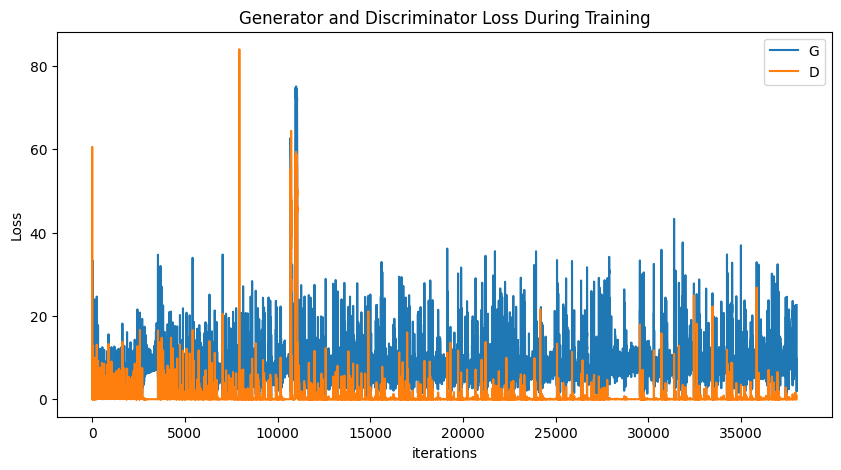

In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
# manualSeed = 999
manualSeed = random.randint(6000, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

# Root directory for dataset
dataroot = "data/training/Edge-Loc"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:2" if (torch.cuda.is_available() and ngpu > 1) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))


# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 64 x 64``
            # 
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 128 x 128``
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            # 
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*16) x 2 x 2``
            # 
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Print the model
print(netD)

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))


# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# path of the directory to save images

main_folder = "generated_imgs_edgeloc"
os.makedirs(main_folder, exist_ok=True)

print("Starting Training Loop...")

# Training Loop
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # generating and sving 100 images per 50 epochs
    if (epoch) % 50 == 0 or epoch == num_epochs - 1:
        dir_generated_imgs = f"generated_image_for_{epoch+1}"
        subfolder_path = os.path.join(main_folder, dir_generated_imgs)
        os.makedirs(subfolder_path, exist_ok=True)
        
        for j in range (100):
            with torch.no_grad():
                noise = torch.randn(1, nz, 1, 1, device=device)
                generated_images = netG(noise).detach().cpu()
                
            img_storage_path = os.path.join(subfolder_path, f"generated_image_num_{j + 1}.png")
            vutils.save_image(generated_images, img_storage_path, normalize=True)

    # Save generator model for specific epochs
    if epoch == num_epochs - 1:
        torch.save(netG.state_dict(), f"generator_epoch_{epoch}.pth")
        torch.save(netG.state_dict(), f"generator_epoch_{epoch}.pt")
        torch.save({
                    'epoch': num_epochs,
                    'model_state_dict': netG.state_dict(),
                    'optimizer_state_dict': optimizerG.state_dict(),
                    'losses': {'G': G_losses, 'D': D_losses},
                }, 'generator_final.pth')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show() 

In [23]:
import argparse
import os
import skimage
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.models import inception_v3
from glob import glob
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from skimage.metrics import peak_signal_noise_ratio

### Frechet Inception Distance (FID), Kernel Inception Distance (KID) & Peak Signal-to-Noise Ratio (PSNR) ###

#Initialize the Frechet Inception Distance 
fid = FrechetInceptionDistance(feature=64)

psnr_values = []

# Initialize the Kernel Inception Distance metric
kid = KernelInceptionDistance(subset_size=50)
# Function to load an image using PIL
def load_image_function(image_path):
    try:
        # Open the image using PIL (assuming the image format is compatible with PIL)
        image = Image.open(image_path)
        # Convert the image to RGB (in case of grayscale images)
        image = image.convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")
        return None


# Define the transformation to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data
])

generated_images_path = 'GANs-EdgeLOC/generated_imgs_edgeloc'

# Path to the directory containing the testing images
testing_images_path = 'data/testing/Edge-Loc/'

# Iterate through each generated folder
for generated_folder_name in os.listdir(generated_images_path):
    generated_folder_path = os.path.join(generated_images_path, generated_folder_name)

    # Skip non-directory items
    if not os.path.isdir(generated_folder_path):
        print(f"{generated_folder_path} is not a directory, skipping.")
        continue

    # Lists to accumulate preprocessed images for the current folder
    generated_images_stack = []
    testing_images_stack = []

    # Preprocess generated images for the current folder
    for generated_image_name in os.listdir(generated_folder_path):
        generated_image_path = os.path.join(generated_folder_path, generated_image_name)

        # Skip non-file items
        if not os.path.isfile(generated_image_path):
            print(f"{generated_image_path} is not a file, skipping.")
            continue

        generated_image = load_image_function(generated_image_path)
        if generated_image:
            preprocessed_generated_image = transform(generated_image)
            preprocessed_generated_image = (preprocessed_generated_image * 255).to(torch.uint8)
            generated_images_stack.append(preprocessed_generated_image)

    # Preprocess testing images (assuming it's the same set for all generated folders)
    for testing_image_name in os.listdir(testing_images_path):
        testing_image_path = os.path.join(testing_images_path, testing_image_name)

        # Skip non-file items
        if not os.path.isfile(testing_image_path):
            print(f"{testing_image_path} is not a file, skipping.")
            continue

        testing_image = load_image_function(testing_image_path)
        if testing_image:
            preprocessed_testing_image = transform(testing_image)
            preprocessed_testing_image = (preprocessed_testing_image * 255).to(torch.uint8)
            testing_images_stack.append(preprocessed_testing_image)

    # Check if testing_images_stack is not empty before stacking
    if testing_images_stack and generated_images_stack:
        generated_images_stack = torch.stack(generated_images_stack)
        testing_images_stack = torch.stack(testing_images_stack)

        psnr_folder_values = []

        for i in range(len(testing_images_stack)):
            psnr_value = peak_signal_noise_ratio(
                testing_images_stack[i].cpu().numpy().transpose(1, 2, 0),
                generated_images_stack[i].cpu().numpy().transpose(1, 2, 0),
                data_range=255
            )
            psnr_folder_values.append(psnr_value)

        # Accumulate PSNR values for the current folder
        psnr_values.extend(psnr_folder_values)

        # Compute mean and std dev of PSNR for the current folder
        psnr_mean = np.mean(psnr_folder_values)
        psnr_std = np.std(psnr_folder_values)

        # Convert accumulated image stacks to tensors
        # Update the FID metric with the generated and testing image stacks for the current folder
        fid.update(generated_images_stack, real=True)
        fid.update(testing_images_stack, real=False)
        kid.update(generated_images_stack, real=True)
        kid.update(testing_images_stack, real=False)

        # Compute FID score for the current folder
        fid_score = fid.compute()
        kid_mean, kid_std = kid.compute()

        # Print PSNR mean and std dev for the current folder
        with open('none_psnr_results.txt', 'w') as psnr_file:
            output = f"{generated_folder_name}: PSNR Mean: {psnr_mean}\n"
            output += f"PSNR Standard Deviation: {psnr_std}\n"
            psnr_file.write(output)

        print(f"{generated_folder_name}: PSNR Mean: {psnr_mean}")
        print(f"PSNR Standard Deviation: {psnr_std}\n")

        # Print FID and KID scores for the current folder
        with open('none_fid_results.txt', 'w') as fid_file:
            output = f"{generated_folder_name}: FID Score: {fid_score.item()}\n"
            fid_file.write(output)

        print(f"{generated_folder_name}: FID Score: {fid_score.item()}")

        with open('none_kid_results.txt', 'w') as kid_file:
            output = f"KID Mean Score: {kid_mean.item()}\n"
            output += f"KID Standard Deviation: {kid_std.item()}\n"
            kid_file.write(output)

        print(f"Folder: {generated_folder_name}, KID Mean Score: {kid_mean.item()}")
        print(f"KID Standard Deviation: {kid_std.item()}\n")

            # Reset the FID and KID metrics for the next folder
            fid.reset()
            kid.reset()
        else:
            print(f"No valid testing images found in {testing_images_path}")

#Inception Score 

# Initialize the Inception Score metric
inception = InceptionScore()

# Iterate through each folder in the specified directory
for folder_name in os.listdir(generated_images_path):
    folder_path = os.path.join(generated_images_path, folder_name)

    if not os.path.isfile(generated_image_path):
            print(f"{generated_image_path} is not a file, skipping.")
            continue
        
    # Check if the item in the directory is a folder
    if os.path.isdir(folder_path):
        folder_images = []
        
        # Iterate through each image in the folder
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            # Load the image (assuming PIL Image format)
            # Replace 'load_image_function' with the appropriate function to load your images
            image = load_image_function(image_path)
            # Apply transformations
            preprocessed_image = transform(image)
            folder_images.append(preprocessed_image)
        
        if folder_images:
            # Stack preprocessed images into a tensor
            folder_images = torch.stack(folder_images)
        
            # Update the Inception Score metric with the preprocessed images for the folder
            inception.update((folder_images * 255).to(torch.uint8))
        
            # Compute Inception Score for the folder
            folder_score_mean, folder_score_std = inception.compute()
        
            # Print mean and standard deviation of Inception Scores for the current folder
            with open('none_inception_score_results.txt', 'a') as file:
                output = f"Folder: {folder_name}\nMean Inception Score: {folder_score_mean.item()}\nStandard Deviation of Inception Scores:{folder_score_std.item()}\n"
                file.write(output)
            print(f"Folder: {folder_name}")
            print(f"Mean Inception Score: {folder_score_mean.item()}")
            print(f"Standard Deviation of Inception Scores: {folder_score_std.item()}")
        
            # Reset the Inception Score metric for the next folder
            inception.reset()
        else:
            print(f"No valid images found in {folder_path}")

IndentationError: unexpected indent (1110434175.py, line 65)